In [1]:
# get the import we need(maybe)
import numpy as np
import time
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
import collections

## 农科院转stata

In [9]:
df = pd.read_excel(f'C:/Users/杜威/Desktop/1.xlsx')

In [89]:
df = []
for file in os.listdir(r'C:\Users\杜威\Desktop\C9'):
    dt = pd.read_excel(f'C:/Users/杜威/Desktop/C8 账面市值比.xlsx')
    df.append(dt.loc[2:, :])
df = pd.concat(df)

In [73]:
df = pd.read_excel(f'C:/Users/杜威/Desktop/A3.xlsx')

In [76]:
df['A3'] = df['AnaAttention'] + df['ReportAttention']

In [13]:
df

,证券代码,year,BS,IDR
0,000001,2014,15.0,0.3333
1,000001,2015,14.0,0.3571
2,000001,2016,11.0,0.3636
3,000001,2017,14.0,0.3571
4,000001,2018,14.0,0.3571
...,...,...,...,...
39063,900957,2019,9.0,0.3333
39064,900957,2020,6.0,0.3333
39065,900957,2021,6.0,0.3333
39066,900957,2022,6.0,0.3333


In [10]:
df = df.loc[2:, :]

In [11]:
df['BS'] = df['Boardsize']
df['IDR'] = df['IndDirectorRatio'] / 100

In [12]:
#df = df[df['Typrep'] == 'A']

def L(x):
    x = str(x)
    x = (6 - len(x)) * '0' + x
    return x
df['证券代码'] = df['Symbol'].map(L)
df['year'] = df['Enddate'].map(lambda x:int(x[:4]))
#df['year'] = df['年份']
df = df[['证券代码', 'year', 'BS', 'IDR']].groupby(['证券代码', 'year'], as_index = False).max()

In [14]:
df.to_excel(r'C:\Users\杜威\Desktop\董事规模比例.xlsx')

In [83]:
df = pd.read_excel(f'C:/Users/杜威/Desktop/HighTech.xlsx', index_col = 0)

In [45]:
for file in ['Bb','Wd']:
    dt = pd.read_excel(f'C:/Users/杜威/Desktop/{file}.xlsx', index_col = 0)
    dt['证券代码'] = dt['证券代码'].map(L)
    df = pd.merge(df, dt, on = ['证券代码', 'year'])

In [4]:
dt = pd.read_excel(f'C:/Users/杜威/Desktop/农科院助研/原始表格/ch6/A2.xlsx', index_col = 0)
df = pd.merge(df, dt, on = ['year'])

In [88]:
df['证券代码'] = df['证券代码'].map(L)
df = df.fillna(1.0)

In [47]:
df.to_excel(r'C:\Users\杜威\Desktop\Y_stable.xlsx')

In [28]:
for col in df.columns[2:]:
    minn = df[col].min()
    maxx = df[col].max()
    df[f'{col}_std'] = (df[col] - minn) / (maxx - minn)
df['X_std'] = df.iloc[:, 7:].sum(axis = 1)

In [38]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=1)  
X_pca = pca.fit_transform(df.iloc[:, 2:8]) 
df['X_pca'] = X_pca.flatten()  

In [51]:
df

,证券代码,year,X_std,X_pca
0,000001,2014,0.065028,9.730194
1,000001,2015,0.07149,7.686452
2,000001,2016,0.059626,5.693458
3,000001,2017,0.097866,6.369537
4,000001,2018,0.288141,44.519594
...,...,...,...,...
33766,900957,2018,0.0,-7.565962
33767,900957,2019,0.0,-7.565962
33768,900957,2020,0.0,-7.565962
33769,900957,2021,0.0,-7.565962


# cl2论文，文本分析

In [3]:
#下载PDF

import requests
from urllib import parse
import re
import os

def collect(year):
    page = 1
    url = 'http://www.cninfo.com.cn/new/fulltextSearch/full'
    headers = {
        'User-Agent': 'Mozilla/5.0(WindowsNT10.0;Win64;x64)AppleWebKit/537.36(KHTML,likeGecko)Chrome/91.0.4472.106Safari/537.36'
        }
    while True:
        year2 = year.replace('社会责任', '可持续发展')
        add = f'?searchkey={parse.quote(year2)}&sdate=&edate=&isfulltext=false&sortName=pubdate&sortType=desc&pageNum={page}'
        res = requests.get(url=url+add, headers=headers).json()
        if not res['announcements']:
            break
        for i in res['announcements']:
            adUrl = i['adjunctUrl']
            title = i['announcementTitle'].strip().replace('<em>', '').replace('</em>', '')
            href = 'http://static.cninfo.com.cn/' + adUrl
            path = f'./pdf/{year}/{validateTitle(title)}.pdf'
            isExists = os.path.exists(path)
            if not isExists:
                pdf = requests.get(url=href, headers=headers).content
                open(path, 'wb').write(pdf)
        if res['totalpages'] < page:
            break
        page += 1
        
def validateTitle(title):
    reStr = r'[\/\\\:\*\?\"\<\>\|]'
    newTitle = re.sub(reStr, '_', title)
    return newTitle

if __name__ == '__main__':
    os.chdir(r'C:\Users\杜威\Desktop\文本分析')
    if not os.path.exists('./pdf'):
        os.makedirs('./pdf')
    years = list(range(2010, 2024, 1))
    for year in years:
        ye = str(year) + ' 社会责任报告' + ' 银行'
        if not os.path.exists('./pdf/' + ye):
            os.makedirs('./pdf/' + ye)
        collect(ye)
        print(f'{year} is Ok!')

2010 is Ok!
2011 is Ok!
2012 is Ok!
2013 is Ok!
2014 is Ok!
2015 is Ok!
2016 is Ok!
2017 is Ok!
2018 is Ok!
2019 is Ok!
2020 is Ok!
2021 is Ok!
2022 is Ok!
2023 is Ok!


In [3]:
#获取pdf目录
def save_dic(name, dic):
    file = open(f'./{name}.txt', 'w')
    for key, value in dic.items():  
        file.write(f"\n{key}: \n")  
        for name in value:
            file.write(f"{name}: \n")
    file.close()
    
def read_dic(name):
    file = open(f'./{name}.txt', 'r')
    content = file.read()
    dictionary = eval(content)
    file.close()
    return dictionary

os.chdir(r'C:\Users\杜威\Desktop\文本分析')
pdf_dic = {}
for year in os.listdir(r'.\pdf')[:-1]:
    for file in os.listdir(f'./pdf/{year}'):
        file = file.strip('.pdf')
        if '：' not in file:
            print(file)
            continue
        bank = file.split('：')[0]
        if bank in pdf_dic:
            pdf_dic[bank].append(file)
        else:
            pdf_dic[bank] = [file]

save_dic('bank dictionary', pdf_dic)


In [ ]:
#PDF转TXT

import os
import io
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from multiprocessing.dummy import Pool
import warnings

os.chdir(r'C:\Users\杜威\Desktop\文本分析')

def pdfTranslate(fileName):
    outfile = path0 + reName(fileName)
    isExists = os.path.exists(outfile)
    size = os.path.getsize(f'/mnt/nas/data_wei/{site}/trade/{name}/datasets/{name1}')
    if isExists and size>:
        return
    try:
        manager = PDFResourceManager()
        output = io.StringIO()
        converter = TextConverter(manager, output, laparams=LAParams())
        interpreter = PDFPageInterpreter(manager, converter)
        with open(f'./pdf/{year}/' + fileName, 'rb') as infile:
            content = []
            for page in PDFPage.get_pages(infile, check_extractable=False):
                interpreter.process_page(page)
            convertedPDF = output.getvalue()
            content.append(convertedPDF)
        with open(outfile, 'wb') as f:
            f.write(''.join(content).encode())
            #print(outfile + '\ttranslate finish!')
        output.close()
        converter.close()
    except Exception as e:
        print('error:' + str(e))
        open(outfile, 'w', encoding='utf-8').write('error')
        
def transMain(year):
    files = []
    for file in os.listdir(f'./pdf/{year}'):
        files.append(file)
    pool = Pool(processes=10)
    pool.map(pdfTranslate, files)
    pool.close()
    pool.join()
    
def reName(fileName):
    return fileName.strip('.pdf') + '.txt'

if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    for year in os.listdir('./pdf')[6:]:
        path0 = f'./txt/{year}/'
        if not os.path.exists(path0):
            os.makedirs(path0)
        transMain(year)

In [ ]:
#文本分析

#衡量语调

import os
resLs = []
keyLs = [i.strip() for i in open('unformal_pos.txt', encoding='utf-8').readlines()]
stopLs = [i.strip() for i in open('stopword.txt', encoding='utf-8').readlines()]
stopLs.append(' ')
stopLs.append('\n')
dic = range(2010, 2024, 1)
for year in dic:
    year = str(year)
    files = os.listdir('./txt/' + year)
    for file in files:
        code = file.split()[0]
        if [year, code] not in resLs:
            resLs.append([year, code])
            txt = open(f'txt/{year}/{file}', encoding='utf-8').read()
            wordNewLs = []
            wordLs = jieba.lcut(txt)
            for word in wordLs:
                if word not in stopLs:
                    wordNewLs.append(word)
            total = len(wordNewLs)
            keyNum = 0
            for key in keyLs:
                keyNum += txt.count(key)
            per = round(keyNum / total, 6)
            print(year, code, total, keyNum, per)
            open('unformal_pos.csv', 'a', encoding='utf-8-sig').write(','.join([str(i) for i in [year, code, total, keyNum, per]]) + '\n')
        else:
            continue

#提取语义
import jieba;
import numpy as np
import pandas as pd
import jieba
import jieba.analyse
text=open('D:/py/2015.txt','r',encoding='utf-8').read()
worddict2=open('D:/py/stopword.txt','r',encoding='utf-8').read()
wordsls=jieba.lcut(text)
wcdict={}
for word in wordsls:
    if word not in worddict2:
        if len(word)==1:
            continue
        else:
            wcdict[word]=wcdict.get(word,0)+1
wcls=list(wcdict.items())
wcls.sort(key=lambda x:x[1],reverse=True) 
for i in range(500): 
    result=wcls[i]
    print(result)

## luo 论文

In [2]:
path = r'C:\Users\杜威\Desktop\2023-9\高管稳定性\raw_data'

In [3]:
df = pd.read_excel(path + r'\CG_Director(2).xlsx', usecols = ['Stkcd', 'Reptdt', 'D0101b', 'PersonID', 'PositionID', 'D0701b', 'D0702b'])

In [142]:
dt = df[1:]
dt.rename(columns = {
    'Stkcd':'Code', 'Reptdt':'year', 'D0101b':'name','PersonID':'ID','PositionID':'type','D0701b':'begin','D0702b':'end'
},
         inplace = True)

In [ ]:
,'P35303'

In [143]:
def get_m(x):
    m_ls = ['P35102','P35104']
    if (type(x) == float) or (len(x.split(',')) == 1):
        if x in m_ls:
            return 2
        else:
            return 1
    else:
        x = x.split(',')
        ls = [2 if i in m_ls else 1 for i in x]
        return max(ls)
dt['m'] = dt['type'].map(get_m)
dt['year'] = dt['year'].map(lambda x:x[:4])

In [131]:
left = 'P35106'
right = 'P35207'
dt = dt[(dt['type'] < left) | (dt['type'] > right)]

In [144]:
dt_ = dt.groupby(['Code','year'],as_index = False).first().groupby(['Code'],as_index = False).count().rename(
    columns = {'year':'num'})
dt = pd.merge(dt,dt_[['Code','num']],on = 'Code',how = 'left')
dt = dt[dt['num'] > 2]

In [38]:
def S1(d1_,y1,y2):
    set_a = set(d1_[d1_['year'] == y1]['name'])
    set_b = set(d1_[d1_['year'] == y2]['name'])
    count12 = len(set_a - set_b)
    count21 = len(set_b - set_a)
    m1 = len(set_a)
    m2 = len(set_b)
    Stmt = (m1 - count12) / m1 * m2 / (m1 + m2) + (m2 - count21) / m2 * m1 / (m1 + m2)
    return [y1,count12, count21, m1, m2, Stmt]

In [39]:
code_ls = set(dt['Code'])
d1 = []
for code in code_ls:
    d1_ = dt[dt['Code'] == code].sort_values(by = 'year')
    year_ls = list(d1_.groupby('year',as_index = False).first()['year'])
    for i in range(len(year_ls)-1):
        d = [code] +  S1(d1_,year_ls[i],year_ls[i+1])
        d1.append(d)
d1 =  pd.DataFrame(d1, columns=['code', 'year', 'St,t+1', 'St+1,t', 'Mt', 'Mt+1', 'Stmt'])
d1 = d1.sort_values(['code','year'])

In [40]:
d1['Stmt'].describe()

count    48291.000000
mean         0.872502
std          0.113142
min          0.000000
25%          0.830281
50%          0.892857
75%          0.944853
max          1.000000
Name: Stmt, dtype: float64

In [41]:
d1.to_csv(r'C:\Users\杜威\Desktop\2023-9\高管稳定性\clean_data\Stmt2.csv')

In [145]:
dt['year'] = dt['year'].astype(int)
def get_pos(x):
    x['position'] = x['m'] / sum(x['m'])
    return x
d1 = dt.groupby(['Code', 'year'], as_index = False).apply(get_pos)

def get_adj(x):
    t = x['position']**2
    x['Adj'] = (1 / sum(t))**0.5
    return x
d1 = d1.groupby(['Code', 'year'], as_index = False).apply(get_adj)

d1['X'] = d1['position'] * d1['Adj']

In [146]:
d1 = d1.reset_index().iloc[:,1:]

In [135]:
def t_wight(data):
    data = list(data)
    L = len(data)
    s = sum([i for i in range(1,L+1)])
    t = 0
    for i in range(1,L+1):
        t += i/s * data[i-1]
    return t

def get_sX(x):
    x['sX'] = x['X'].rolling(3).apply(t_wight)
    return x

In [136]:
def get_Stab(data):
    code = data['Code'].min()
    dy = data.groupby('year',as_index = False).first()
    y_ls = list(dy['year'])
    df = []
    for year in y_ls[2:]:
        name_ls = list(data[data['year'] == year]['name'])
        df1 = data[data['year'] >= (year - 2)][data['year'] <= year]
        df1['sX'] = ((df1['year'] - year + 3) / 6 * df1['X'])
        d10 = df1[['name', 'sX']].groupby(['name']).sum().loc[name_ls, :]
        Stab = sum(d10['sX'] ** 2)
        df.append([code, year, Stab])
    df = pd.DataFrame(df, columns = ['Code', 'year', 'Stab'])
    return df

In [147]:
dt = d1.groupby(['Code'], as_index = False).apply(get_Stab)

In [148]:
dt = dt.reset_index().iloc[:, 2:]

In [149]:
dt[dt['Code'] == '300750']

,Code,year,Stab
23995,300750,2020,1.000000
23996,300750,2021,0.981812
23997,300750,2022,0.934854


In [151]:
dt['Stab'].describe()

count    43694.000000
mean         0.862674
std          0.100571
min          0.250000
25%          0.816982
50%          0.885896
75%          0.933580
max          1.000000
Name: Stab, dtype: float64

In [152]:
dt.to_csv(r'C:\Users\杜威\Desktop\2023-9\高管稳定性\clean_data\Stab3.csv')

# get package

In [3]:
#!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple semopy

# Data Clean

In [6]:
def str2num(df):
    df_str_index=[]
    for column in df.columns:
        if type(df[column][0])==str:
            df_str_index.append(column)
    #turn the str into int

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    for name in df_str_index[1:]:
        le.fit(df[name])
        df[name] = le.transform(df[name])
    return df

def sequeen2num(df):
    encode_map={
        'Q3':{'18-33（1990年以后）':1, '18以下':0, '34-43（1980年后）':2, '44以上（1980年前）':3},
        'Q4':{'其他':1, '单身':0, '已婚已育':2, '已婚未育':1},
        'Q5':{'专科':1, '本科':2, '硕士及以上':3, '高中及以下':0},
        'Q6':{'个体户或自由职业':2, '公职人员':0, '其他':1, '外企人员':1, '民营企业人员':2},
        'Q7':{'5000-8000':1, '8000-12000':2, '<5000':0, '>12000':3},
        'Q10':{'100-200元':1, '100元以内':0, '200-300元':2, '300-500元':3, '500以上':4}
        }
    for name in encode_map:
        df[name] = np.array([encode_map[name][x] for x in df[name]])
    return df

def clean_xls():
    df=pd.read_excel(r'C:\Users\杜威\Desktop\宠物直播与电商\样本处理后+分析.xlsx',header=1,sheet_name=['样本'])
    df=df['样本']
    df=sequeen2num(df)
    df=str2num(df)
    df['PC']=df[['Q5_1','Q5_2','Q5_3','Q5_4','Q5_5']].sum(axis=1)
    df['BC']=df['Q7']
    df['NFC']=df[['Q5','Q3']].sum(axis=1)
    
    return df

In [7]:
df=clean_xls()

In [8]:
df.to_csv(r'C:\Users\杜威\Desktop\宠物直播与电商\data.csv')

# ML

In [91]:
def plot_model(df_all,y,x):
    from sklearn.model_selection import train_test_split
    Y = np.array(df_all[y])
    X = np.array(df_all[x])
    X_train, X_test, Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=521)
    
    from xgboost import XGBRegressor
    other_params = { 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    xgb = XGBRegressor( n_estimators=750,learning_rate=0.005,**other_params)
    xgb.fit(X_train, Y_train)
    y_pred_xgb_num=xgb.predict(X_test)
    
    plot_pre(Y_test,y_pred_xgb_num)
    
    df_virt,X_virt=get_virtual(df_all[x],x)
    return plot_virtual(xgb,df_virt,X_virt)

In [42]:
def plot_pre(y1,y2):
    y1=y1.reshape(-1)
    x=np.array(range(len(y1)))
    plt.figure(figsize=(15,8))
    plt.plot(x,y1,label='real')
    plt.plot(x,y2,label='pred')
    corr=np.corrcoef(y1,y2)[0][1]
    plt.title(f'corr={corr}')
    plt.legend()
    plt.show()

In [92]:
def get_virtual(df,X):
    df_virtual=df[X]
    for col in X[:7]:
        df_virtual[col]=df[col].mean()
    l=len(df)
    for col in X[7:]:
        df_virtual[col]=np.random.uniform(min(df[col]),max(df[col]),l)
    return df_virtual,X[7:]

def plot_virtual(xgb,df,X):
    x=np.array(df)
    Y=xgb.predict(x)
    for col in X:
        plt.figure(figsize=(15,8))
        corr=np.corrcoef(df[col],Y)[0][1]
        plt.scatter(df[col],Y,label=f'{corr}')
        plt.title(f'x_virt={col}')
        plt.legend()
        plt.show()
    return Y,df[X]

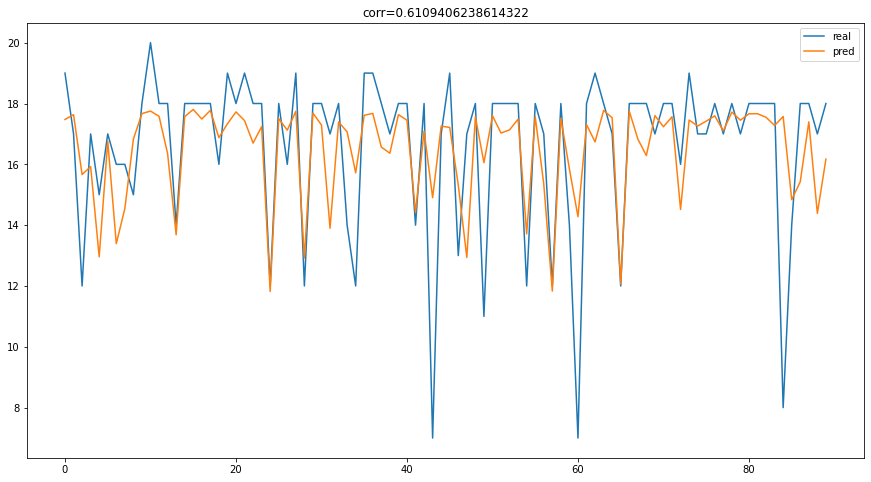

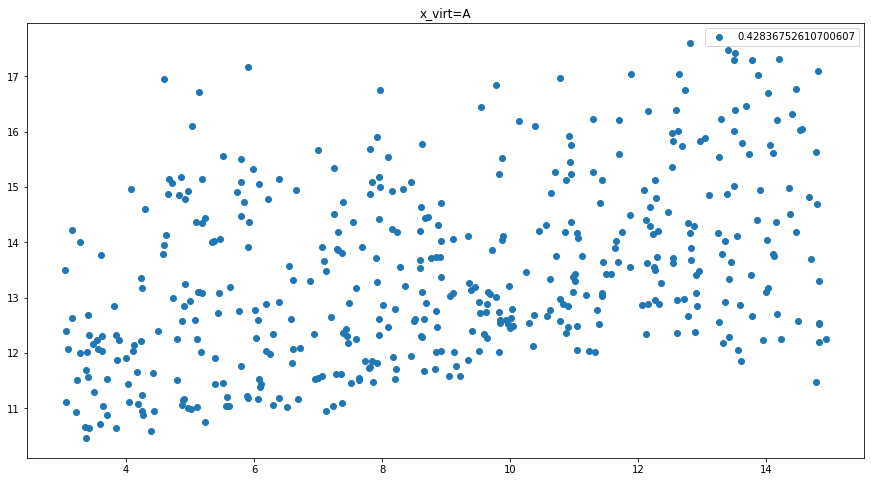

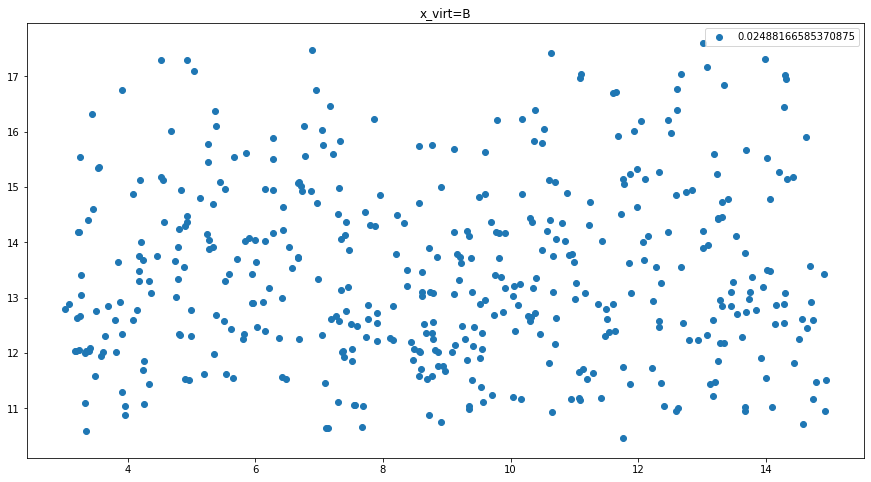

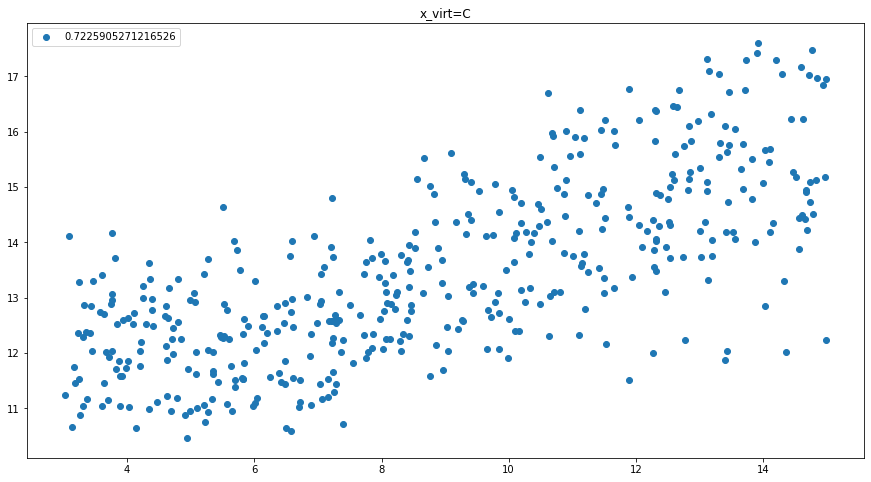

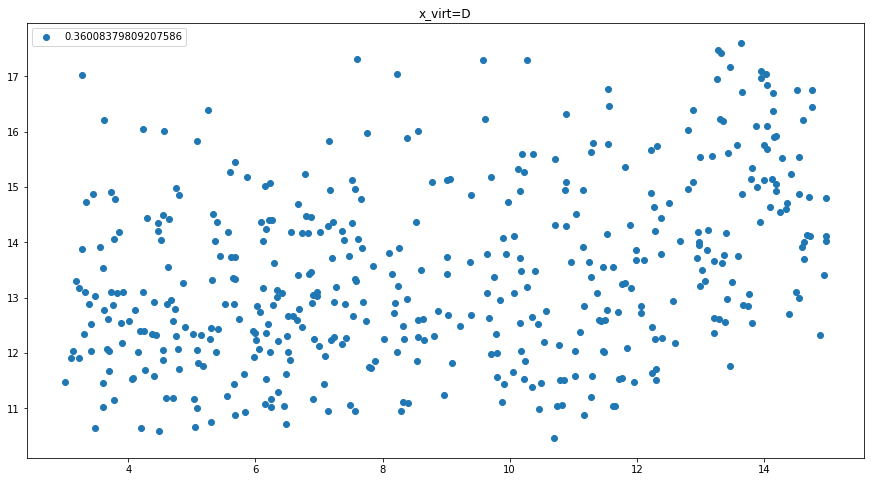

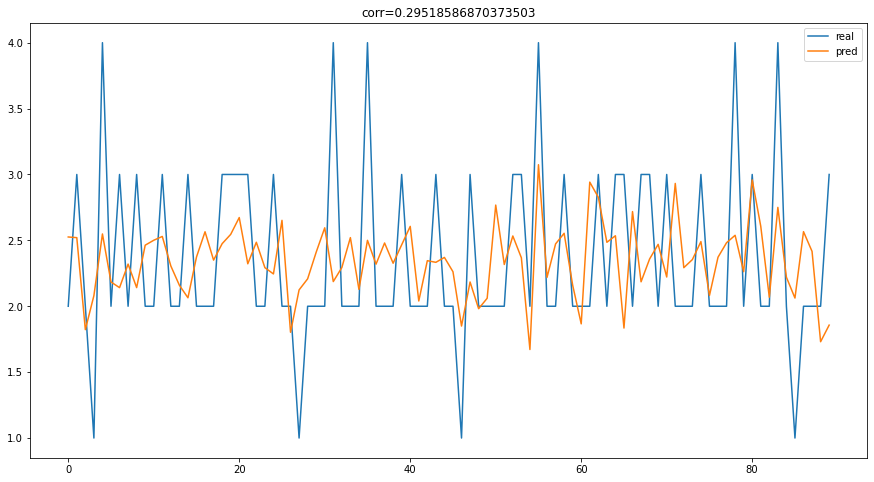

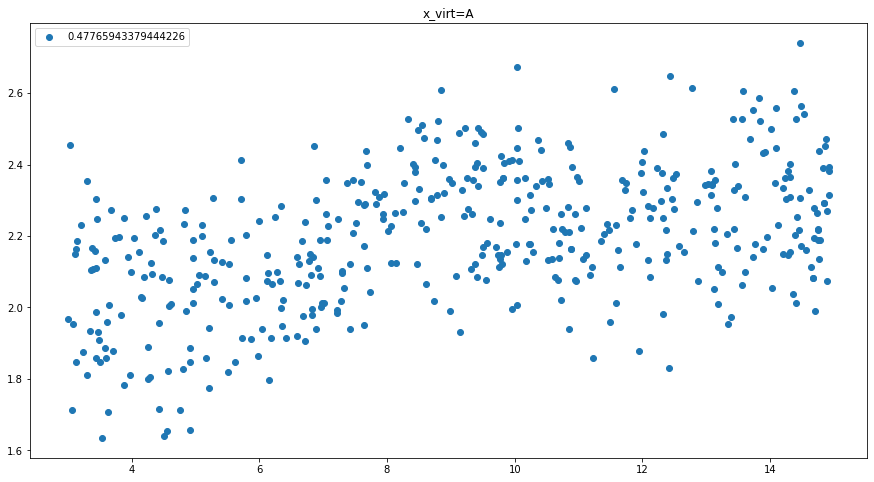

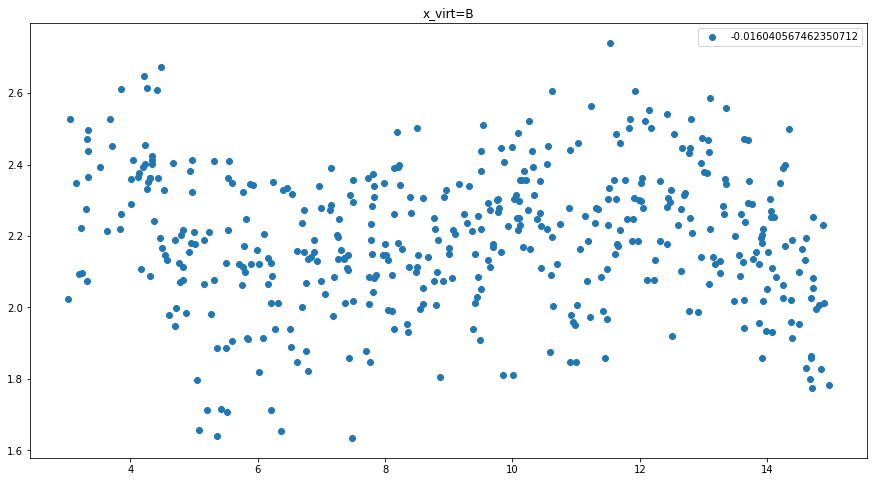

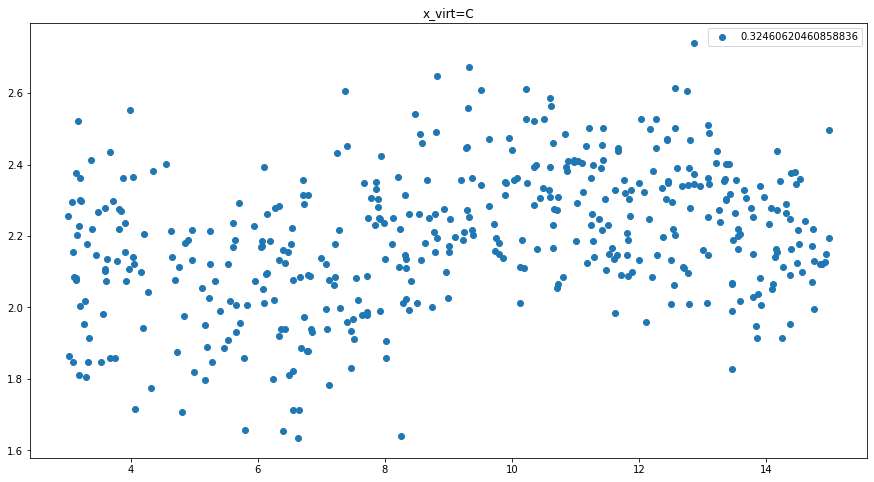

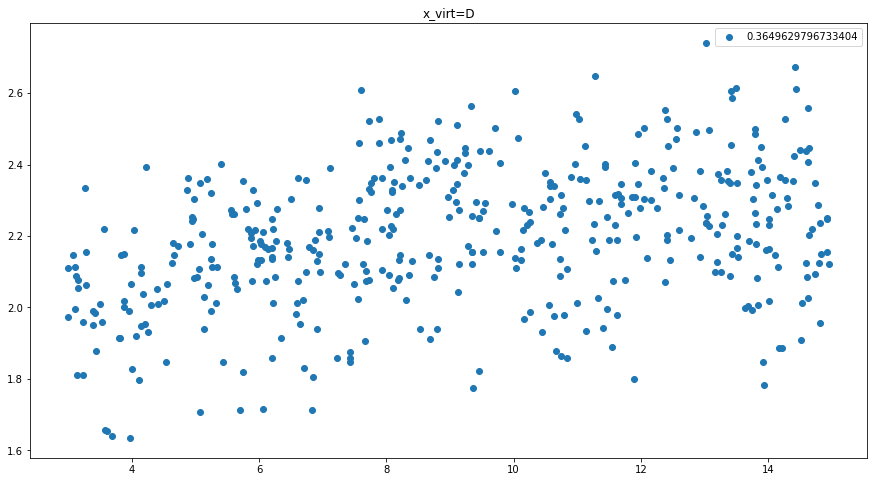

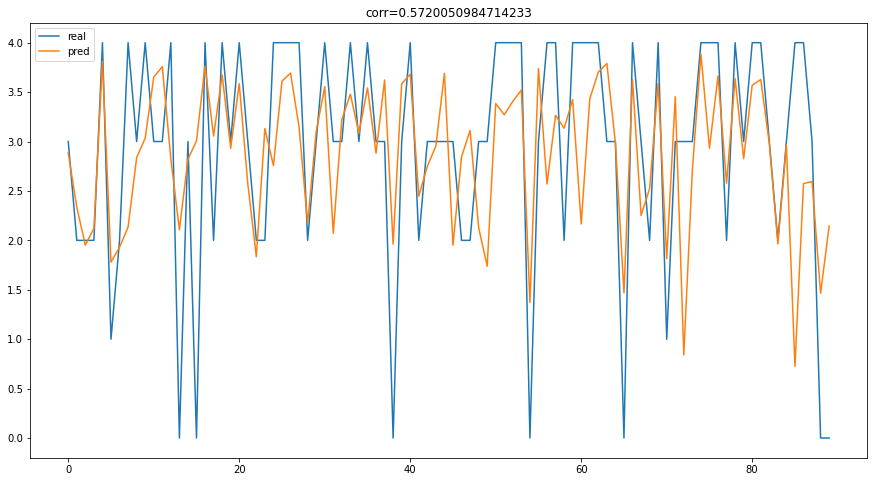

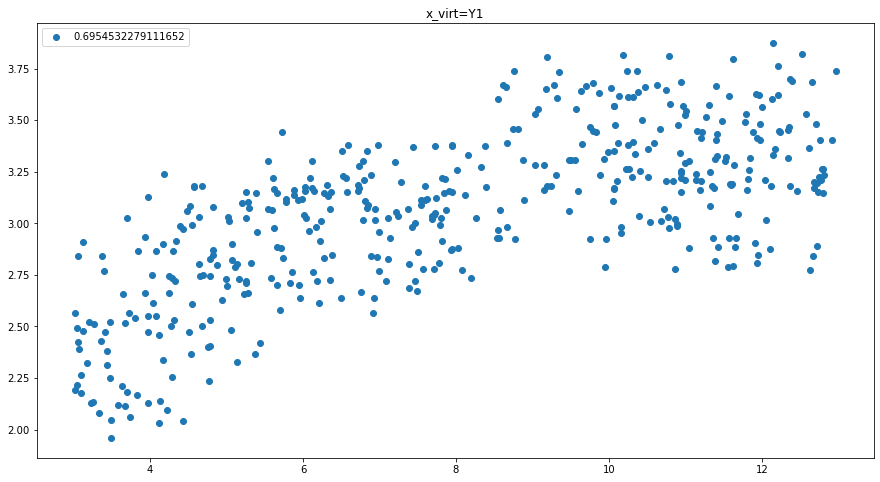

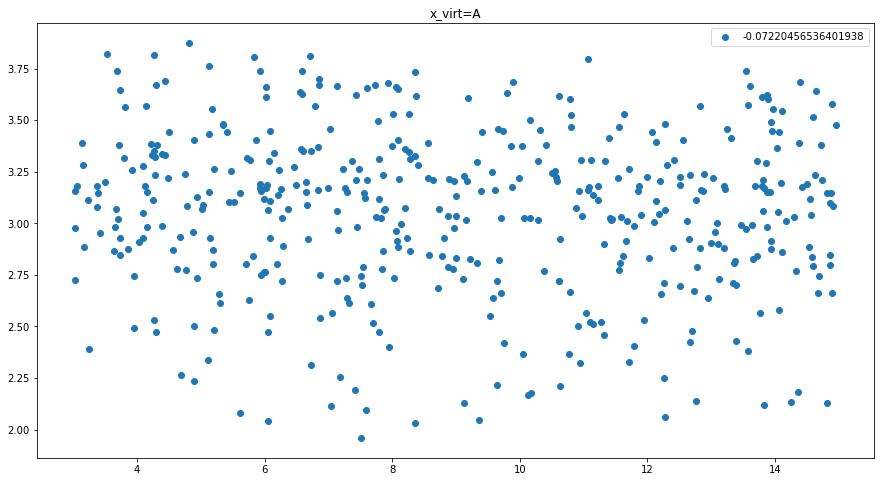

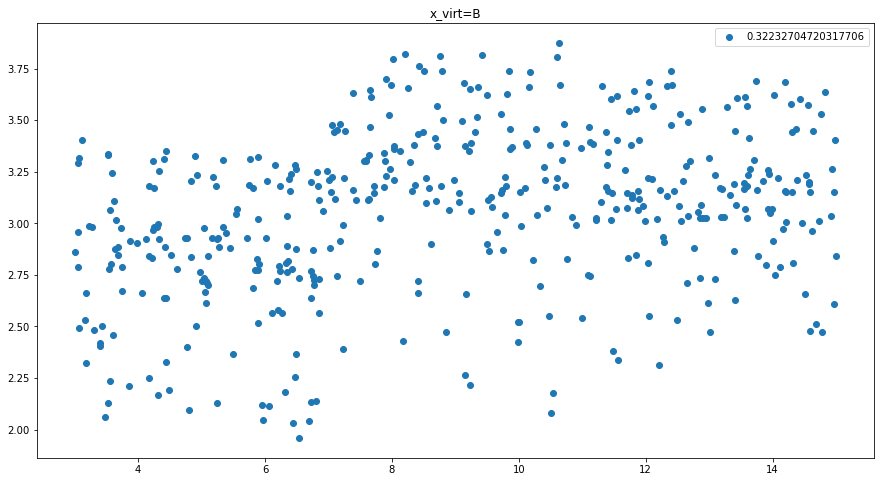

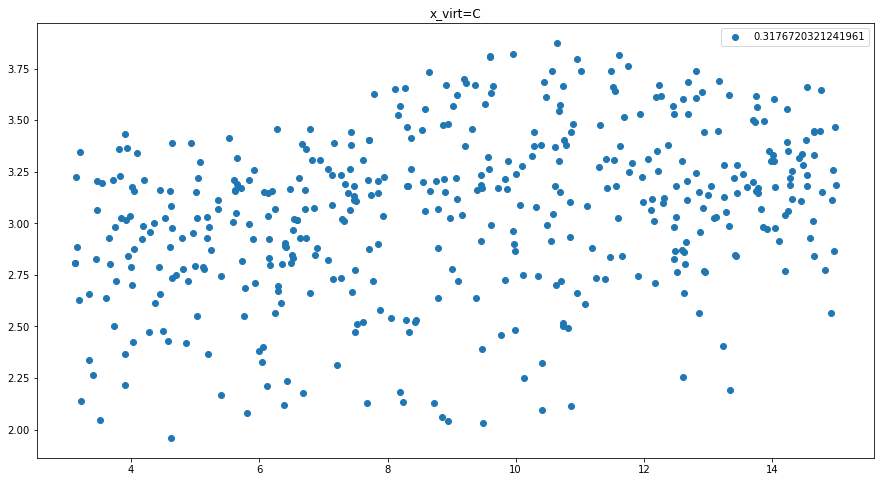

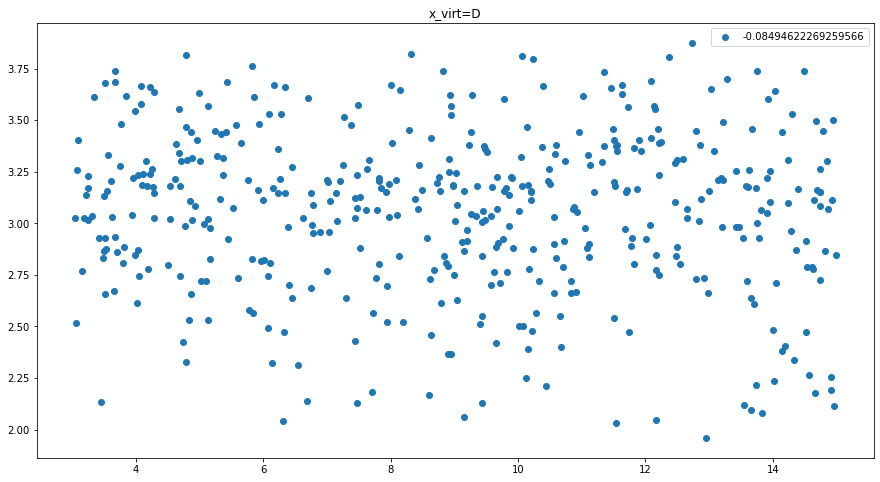

In [103]:
Y1,X1=plot_model(df,Y1_y,Y1_x)
Y2,X2=plot_model(df,Y2_y,Y2_x)
C,Xc=plot_model(df,C_y,C_x)

# OLS

In [11]:
import statsmodels.api as sm
Y=df['Y']
X=df[['A','B','C','D']+list(df.columns[:7])]
model = sm.OLS(Y,X) #生成模型
result = model.fit() #模型拟合
#result.summary() #模型描述

In [65]:
from scipy.stats import pearsonr, t

# 生成样本数据
x = df['F']
y = df['resid']

# 计算相关系数及其显著性
r, p = pearsonr(x, y)
t_val = r * np.sqrt(len(x) - 2) / np.sqrt(1 - r**2)
p_val = 2 * t.sf(np.abs(t_val), len(x) - 2)

# 输出结果
print(f"Pearson correlation coefficient: {r:.4f}")
print(f"t-value: {t_val:.4f}")
print(f"p-value: {p_val:.4f}")

Pearson correlation coefficient: -0.2700
t-value: -5.9279
p-value: 0.0000


# SEM

In [4]:
import semopy as sem
from semopy import Model

In [94]:
df.columns

Index(['作答ID', 'Q1', 'Q2', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6',
       'Q4_1', 'Q4_2', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'A1', 'A2',
       'A3', 'B1', 'B2', 'B3', 'Q0', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'F1',
       'F2', 'F3', 'F4', 'Y1', 'Y2', 'Y3', 'Q1.1', 'Q2.1', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12_1', 'Q12_2', 'Q12_3',
       'Q12_4', 'Q12_5', 'Cons'],
      dtype='object')

In [12]:
df['PV1']=df[['Q10']]
df['PV2']=df[['Q4_1','Q4_2']].sum(axis=1)
df['PV3']=df[['Q5_1','Q5_2','Q5_3','Q5_4','Q5_5']].sum(axis=1)

In [116]:
desc = '''
    # measurement model
    A =~ A1 + A2 + A3
    B =~ B1 + B2 + B3
    C =~ C1 + C2 + C3
    D =~ D1 + D2 + D3
    PT =~ F1 + F2 + F3 + F4
    #PV =~ Q10 + Q4_1 + Q4_2 + Q5_1 + Q5_2 + Q5_3 + Q5_4
    Y =~ Y1 + Y2 + Y3
    #BC =~Q7 + Q6
    #SP =~Q5 + Q4
    # regressions
    PT ~  A + C + B + D
    Y ~  A + D + B + C + PT
    '''

In [117]:
model=Model(desc)
fit=model.fit(df)

In [118]:
inspect = model.inspect()

In [119]:
params=inspect[:10]
inspect[:10]

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,PT,~,A,0.240332,0.054696,4.393926,0.000011
1,PT,~,C,0.488236,0.050903,9.591598,0.0
2,PT,~,B,0.144827,0.045152,3.207568,0.001339
3,PT,~,D,0.098843,0.045842,2.156153,0.031072
4,Y,~,A,0.305345,0.053325,5.726131,0.0
5,Y,~,D,0.183769,0.04286,4.287692,0.000018
6,Y,~,B,0.118616,0.042031,2.822139,0.00477
7,Y,~,C,0.153801,0.053755,2.861172,0.004221
8,Y,~,PT,0.242519,0.061976,3.913096,0.000091
9,A1,~,A,1.000000,-,-,-


In [120]:
stats = sem.calc_stats(model)
stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,137,171,316.321314,3.330669e-16,4494.580752,0.958525,0.929622,0.912155,0.929622,0.948232,0.054053,104.590996,322.263209,0.704502


In [10]:
from see import see
see(sem)

    ismodule                help()                  .Model()                .ModelEffects()
    .ModelGeneralizedEffects()                      .ModelMeans()           .Optimizer()            .bias_correction()
    .calc_stats()           .constraints            .create_regularization()                        .efa
    .effects                .estimate_means()       .examples               .gather_statistics()    .inspector
    .means                  .model                  .model_base             .model_effects
    .model_generalized_effects                      .model_generation       .model_means            .multigroup
    .name                   .optimizer              .parser                 .plot                   .polycorr
    .regularization         .report()               .semplot()              .solver                 .startingvalues
    .stats                  .unbias                 .univariate_blup        .utils

In [121]:
latent=predict(model,df)

NameError: name 'predict' is not defined